In [77]:
"""
Import nécessaire au fonctionnement du .ipynb
"""
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
import pandas as pd
from math import sqrt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from sklearn import metrics
import pickle
from sklearn.utils import resample
import os

In [78]:
def savePickle(filename,data):
    """
    Cette fonction va recuperer des donnes et les sauvegarder au format .pickle
    
    @Param1 String filename    = Le nom du fichier que l'on souhaite donne
    @Param2 Object data        = Object que l'on souhaite sauvegarder
    """
    # Sauvegarde du modele
    with open('./'+filename+'.pickle', 'wb') as f:
        pickle.dump(data, f)

In [79]:
def Training(RecoveryfileName, test_size, save='save'):
    """
    Cette fonction va recuperer dans un dataframe chaque feature, 
    Elle effectuer un apprentissage et donne la matrice de confusion
    
    @Param1 String : RecoveryfileName = Nom du fichier
    @Param2 float  : test_size        = taille de l'appentissage de test
    @Param3 String : save             = Sauvegarde du modele en format pickle     default='save'    
    """
    # On récupère les données dans un dataframe
    dfFeature = pd.read_csv("./"+RecoveryfileName+".csv")
    array = dfFeature.values
    # On stock dans X toutes les valeurs sauf les labels
    X = array[:,0:len(dfFeature.columns)-1]
    # On stock dans Y seulement les labels
    Y = array[:,len(dfFeature.columns)-1]
    Y=Y.astype('int')
    
    # On effectue un apprentissage 
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=test_size)  

    # On défini le modèle de regression
    LR_Model = LogisticRegression(C=0.1, max_iter=20, fit_intercept=True, n_jobs=3, solver="liblinear")

    # On entraine le modèle
    LR_Model.fit(Xtrain, Ytrain)
    # Affichage du score de l'entrainement
    print(LR_Model.score(Xtest, Ytest))
    LR_Model.score(Xtest, Ytest)
    LR_Model.predict(Xtest)
    
    # Affichage de la matrice de confusion du modele
    metrics.plot_confusion_matrix(LR_Model, Xtest, Ytest)
    # On save le modele en format Pickle
    if(save.lower()=='save'):
        savePickle('LR_Model',LR_Model)

In [80]:
def TrainingUpOrDownSample(RecoveryfileName, test_size, UpOrDown, save='save'):
    """
    Cette fonction va recuperer dans un dataframe chaque feature, 
    elle va effectuer un UpSampling ou DownSampling afin de retirer
    l'effet de la feature majoritaire et donc obtenir un score plus représentatif
    Elle effectuer un apprentissage et donne la matrice de confusion
        
    @Param1 String : RecoveryfileName = Nom du fichier
    @Param2 float  : test_size        = taille de l'appentissage de test
    @Param3 String : UpOrDown         = Choix entre UpSampling ou DownSampling    default='Up'
    @Param4 String : save             = Sauvegarde du modele en format pickle     default='save'
    """
    # On récupère les données dans un dataframe
    dfFeature = pd.read_csv("./"+RecoveryfileName+".csv")    
    
    # liste des indices des emotions
    indexEmotion=[0,1,3,4,5,6,7]

    # On initialise un dataframe vide pour y ajouter les valeurs apres les opérations de sample
    df_totality = pd.DataFrame()
    df_totality = df_totality.fillna(0) # with 0s rather than NaNs    
    
    #On recupere la taille max du dataframe 
    maxIndex=len(list(dfFeature.columns.values))-1
    # On regarde si l'utilisateur souhaite un UpSample
    if(UpOrDown.lower() == 'up'):
        # On fixe une valeur null pour initier la recherche du plus grand element
        highest = 0
        # On récupère la feature avec le plus de donner pour proceder au UpSample 
        for pos1 in indexEmotion :
            number = len(dfFeature[dfFeature[str(maxIndex)]==pos1])
            if(number > highest):
                highestIndex, highest = pos1, len(dfFeature[dfFeature[str(maxIndex)]==pos1])
                
        # On procède au Upsample sur chaque feature         
        for pos2 in indexEmotion:
            try:
                df_majority = dfFeature[dfFeature[str(maxIndex)]==highestIndex]
                df_minority = dfFeature[dfFeature[str(maxIndex)]==pos2]
                # Si c'est l'index de la feature avec le plus de donnée, alors on le copie tel quel dans le dataframe
                if(pos2==highestIndex):
                    df_totality = pd.concat([df_totality, df_majority])
                # On redimensionne l'element pour qu'il ai le meme nombre de sample que la feature majoritaire
                else:
                    df_minority_upsampled = resample(df_minority ,replace=True, n_samples=len(df_majority), random_state=0)
                    df_totality = pd.concat([df_totality, df_minority_upsampled])
                    #df_minority_upsampled.to_csv("./df_minority_upsampled_"+str(i)+".csv", index=False)
            except:
                print("Error during sample")
                
    # On regarde si l'utilisateur souhaite un DownSample
    elif(UpOrDown.lower() == 'down'):
        # On fixe une valeur assez haute pour initier la recherche du plus petit element
        smallest = 100000
        # On récupère la feature avec le moins de donner pour proceder au DownSample 
        for pos3 in indexEmotion :
            number = len(dfFeature[dfFeature[str(maxIndex)]==pos3])
            if(number < smallest):
                smallestIndex, smallest = pos3, len(dfFeature[dfFeature[str(maxIndex)]==pos3])
        # On procède au Downsample sur chaque feature 
        for pos4 in indexEmotion:
            try:
                df_minority = dfFeature[dfFeature[str(maxIndex)]==smallestIndex]
                df_majority = dfFeature[dfFeature[str(maxIndex)]==pos4]
                # Si c'est l'index de la feature avec le moins de donnée, alors on le copie tel quel dans le dataframe
                if(pos4==smallestIndex):
                    df_totality = pd.concat([df_totality, df_minority])
                    print("done down")
                # On redimensionne l'element pour qu'il ai le meme nombre de sample que la feature minoritaire
                else:
                    df_minority_downsampled = resample(df_majority ,replace=True, n_samples=len(df_minority), random_state=0)
                    df_totality = pd.concat([df_totality, df_minority_downsampled])
                    #df_minority_downsampled.to_csv("./df_minority_downsampled_"+str(i)+".csv", index=False)
            except:
                print("Error during sample")
        
    df_totality.to_csv("./df_totality.csv", index=False)
    
    # On recupere le dataframe apres processus de sampling
    dfFeatureAfterSampling = pd.read_csv("./df_totality.csv")
    array = dfFeatureAfterSampling.values
    # On stock dans X toutes les valeurs sauf les labels
    X = array[:,0:len(dfFeatureAfterSampling.columns)-1]
    # On stock dans Y seulement les labels
    Y = array[:,len(dfFeatureAfterSampling.columns)-1]
    Y=Y.astype('int')
    
    # On effectue un apprentissage 
    Xtrain, Xval, Ytrain, Yval = train_test_split(X,Y,test_size=test_size)  

    # On défini le modèle de regression
    LR_Model = LogisticRegression(C=0.1, max_iter=20, fit_intercept=True, n_jobs=3, solver="liblinear")

    # On entraine le modèle
    LR_Model.fit(Xtrain, Ytrain)
    # Affichage du score de l'entrainement
    print("TrainingUpOrDownSample",LR_Model.score(Xval, Yval))
    LR_Model.score(Xval, Yval)
    LR_Model.predict(Xval)
    
    # Affichage de la matrice de confusion du modele
    metrics.plot_confusion_matrix(LR_Model, Xval, Yval)
    
    #Suppression du fichier csv df_totality
    os.remove("./df_totality.csv")
    
    # On save le modele en format Pickle
    if(save.lower()=='save'):
        savePickle('LR_Model',LR_Model)

In [81]:
def bestFeatureCSV(fileName, saveName):
    """
    Cette fonction va recuperer les informations du fichier mis en premier paramètre et va ensuite effectuer une selection des meilleures features.
    Une fois les features selectionnees on sauvegarde les donnees dans un second fichier qui est nomme via le deuxieme parametre.
    Le troisieme parametre correspond au nombre de features que l'on souhaite garder pour notre entrainement
        
    @Param1 String  : fileName        = Nom du fichier ou l'on souhaite recuperer les donnees
    @Param2 String  : saveName        = Nom du fichier ou l'on souhaite sauvegarder les meilleures features (colonnes)
    @Param3 int     : nbFeature       = Correspond au nombre de colonne que l'on souhaite garder
    """    
    dfSample = pd.read_csv("./"+fileName+".csv")
    Title = list(dfSample.columns.values)
    #print(Title)
    array = dfSample.values
    if(fileName=="features_test"):
        X = array[:,1:len(dfSample.columns)]
        Y = array[:,len(dfSample.columns)-1]
    else:
        X = array[:,1:len(dfSample.columns)-1]
        Y = array[:,len(dfSample.columns)-1]

    Y=Y.astype('int')
    
    # Feature extraction
    test = SelectKBest(score_func=chi2, k=140)
    fit = test.fit(X, Y)
    # Summarize scores
    np.set_printoptions(precision=3)

    features = fit.transform(X)

    listOfIndex=[]
    for index, value in enumerate(fit.get_support()) :
        if (value==True):
            listOfIndex.append(index)
    # Summarize selected features
    #print(features[0:91,:])
    features = np.hstack((features, np.atleast_2d(Y).T))    
    pd.DataFrame(features).to_csv("./"+saveName+".csv", index=False)
    return listOfIndex

In [82]:
def fullTraining(fileName, save='save'):
    """
    Cette fonction va effectuer un entrainement avec toute la base d'apprentissage sur un modele de regression lineaire.
    Le modèle est sauvegardé au format .pickle pour pouvoir etre reutiliser
        
    @Param1 String  : fileName      = Nom du fichier ou l'on souhaite recuperer les donnees
    @Param2 String  : save          = Sauvegarde du modele en format pickle     default='save'
    """    
    dfTraining = pd.read_csv("./"+fileName+".csv")
    array = dfTraining.values
    X = array[:,1:len(dfTraining.columns)-1]
    Y = array[:,len(dfTraining.columns)-1]
    Y=Y.astype('int')
    
    # On défini le modèle de regression
    LR_Model = LogisticRegression(C=0.1, max_iter=20, fit_intercept=True, n_jobs=3, solver="liblinear")

    # On entraine le modèle
    LR_Model.fit(X, Y)

    # Affichage du score de l'entrainement
    print("Fulltraining", LR_Model.score(X, Y))
    LR_Model.score(X, Y)
    LR_Model.predict(X)    
    
    #On save le modele en format Pickle
    if(save.lower()=='save'):
        savePickle('LR_Model',LR_Model)

In [83]:
def replaceIndex(listOfIndex, fileWithHeader, fileToReplaceHeader):
    """
    Cette fonction va remplacer les entetes du fichier mis en parametre pour pouvoir y mettre les entetes respectives
        
    @Param1 String  : listOfIndex           = Liste contenant tout les index que l'on garde lors du bestKFeature()
    @Param2 String  : fileWithHeader        = Fichier contenant tout les noms des entetes
    @Param3 String  : fileToReplaceHeader   = Fichier ou l'on souhaite remplacer son entete par les bon noms
    """        
    dfHeader = pd.read_csv("./"+fileWithHeader+".csv")
    dfReplace = pd.read_csv("./"+fileToReplaceHeader+".csv")

    listOfTitle=[]

    for valeur, titre in zip(listOfIndex, list(dfHeader.columns.values)):
        listOfTitle.append(dfHeader.columns.values[valeur+1])
    listOfTitle.append('label')
    
    for idx, NewTitre in enumerate(listOfTitle):
        dfReplace.columns.values[idx]=NewTitre

    dfReplace.to_csv("./"+fileToReplaceHeader+".csv", index=False)

In [84]:
def getHeaderList(filename):
    """
    Cette fonction retourner la liste des entetes d'un fichier
        
    @Param1 String  : fileName      = Nom du fichier ou l'on souhaite recuperer les donnees
    """        
    dfHeader = pd.read_csv("./"+filename+".csv")
    header=list(dfHeader.columns.values[:-1])
    return header
    

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


TrainingUpOrDownSample 0.9567404426559356


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Fulltraining 0.9418282548476454


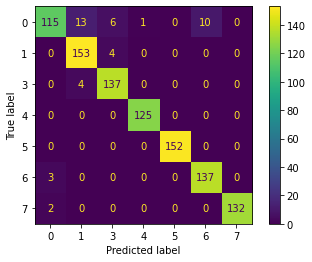

In [86]:
SavedNames=["trainSetWithFeatures"]
FinalSavedNames=["features_train"]
listNumberOfFeature=[140]

for i in listNumberOfFeature:
    listOfIndexTraining=[]
    for (Name, FinalName) in zip(SavedNames, FinalSavedNames): 
        listOfIndexTraining=bestFeatureCSV(Name, FinalName)
        TrainingUpOrDownSample(FinalName, 0.3, 'up', 'no')
        replaceIndex(listOfIndexTraining, Name, FinalName)
        fullTraining(FinalName)

#print(listOfIndexTraining)
#Suppression des fichiers temporaire (SavedNames)
#os.remove("./trainSetWithFeatures.csv")

#On recupere les noms des entetes que l'on a garde dans le features_train et on le sauvegarde au format .pickle pour pouvoir les utiliser
listOfHeader = getHeaderList('features_train')
savePickle('listOfIndex',listOfHeader)